In [1]:
import Pkg;
Pkg.activate("../")
#Pkg.instantiate()
#Pkg.add(url = "https://github.com/RalphAS/Pseudospectra.jl")

  Activating project at `~/Code/ExperimentsPseudospectra.jl/notebook`


In [2]:
using Pseudospectra, Plots

In [3]:
Pkg.status()

Status `~/Code/ExperimentsPseudospectra.jl/notebook/Project.toml`
  [77e4f72b] BallArithmetic v0.1.1
⌅ [d1acc4aa] IntervalArithmetic v0.20.9
  [91a5bcdd] Plots v1.40.14
  [d6c5b33e] Pseudospectra v0.3.0-DEV `https://github.com/RalphAS/Pseudospectra.jl#master`
  [6103b61f] RigorousInvariantMeasures v0.2.3
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


# Our example

We start by defining the Blashke product 
$$
B_{\mu}(z) = \frac{z (\mu - z)} {1 - \bar{\mu} z},
$$
with $\mu = \frac{17\sqrt{2}}{32} e^{i \pi/8}$.

In [4]:
r = sqrt(2)*(3/8) 
ϕ = π / 8

max_r = 10.0
μ = r * exp(im * ϕ)
B(z; μ=μ) = (z * (μ - z)) / (1 - μ' * z)

B (generic function with 1 method)

# Non rigorous exploration of the Pseudospectrum

We fix the truncation size for the Galerkin approximation.

In [5]:
K = 128
N = 2*K+1

257

We start by writing the Blashke product as an interval map

In [6]:
S(x) = 0.5 + atan((sin(2 * pi * x) - r * sin(ϕ)) / (cos(2 * pi * x) - r * cos(ϕ))) / pi

S (generic function with 1 method)

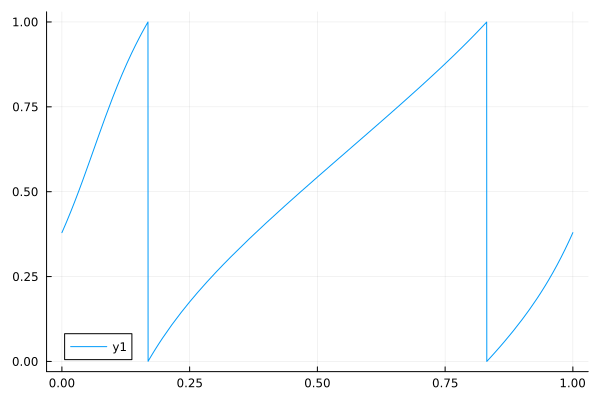

In [7]:
using Plots
plot(S, 0, 1)

In [8]:
using RigorousInvariantMeasures
FourierBasis = RigorousInvariantMeasures.FourierAdjoint(K, 65536)
P = DiscretizedOperator(FourierBasis, S)

┌ Warning: This basis breaks the usual interface of the package, i.e., 
│     the dynamic is input as a function instead than a PwMap
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierAdjoint.jl:21
┌ Info: Assembling operator, the Newton stopping options are 
│       ϵ = 1.0e-14, max_iter = 100
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/GenericAssembler.jl:145
┌ Info: 257
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierCommon.jl:78
┌ Info: 128
└ @ RigorousInvariantMeasures /home/isaia/.julia/packages/RigorousInvariantMeasures/xFVMn/src/Basis/Fourier/FourierCommon.jl:82
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


NonIntegralPreservingDiscretizedOperator{LinearAlgebra.Adjoint{Complex{Interval{Float64}}, Matrix{Complex{Interval{Float64}}}}, Vector{Float64}, LinearAlgebra.Adjoint{Complex{Interval{Float64}}, Vector{Complex{Interval{Float64}}}}}(Complex{Interval{Float64}}[[0.999999, 1.00001] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im … [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im [-2.36499e-14, 2.36499e-14] + [-2.36499e-14, 2.36499e-14]im; [-2.52571e-14, 2.51779e-14] + [-2.51918e-14, 2.52433e-14]im [0.489961, 0.489962] + [-0.202949, -0.202948]im … [-2.51781e-14, 2.52569e-14] + [-2.52052e-14, 2.52299e-14]im [-2.52009e-14, 2.52341e-14] + [-2.52042e-14, 2.52309e-14]im; … ; [-2.67841e-14, 2.66439e-14] + [-2.66741e-14, 2.67538e-14]im [-2.67214e-14, 2.67066e-14] + [-2.66643e-14, 2.67637e-14]im … [0.198873, 0.198874] + [0.198873, 0.198874]im [-2.67885e-14, 2.66394e-14] + [-2.66999e-14, 2.67281e-14]im; [-2.52571e-14, 2.51779e-14] + [-2.52433e-1

Computing pseudospectra... 100%|████████████████████| Time: 0:00:02


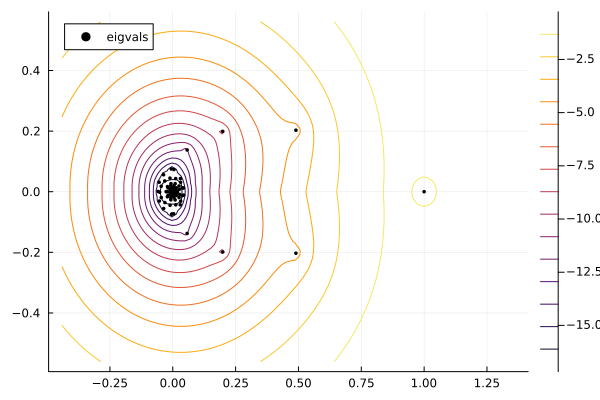

In [9]:
import IntervalArithmetic
midI = IntervalArithmetic.mid
radI = IntervalArithmetic.radius

midP = midI.(real.(P.L)) + im * midI.(imag.(P.L))
spectralportrait(midP)

# Numerical oracle for the constants

In this section we do some numerical computations to narrow down the set of parameters. Later on, we will use self-validated numerical methods (Interval Arithmetic) to certify the 
numerical values we computed now. We do this since numerical computations are inexpensive, while self validated methods may be more time-consuming.

In [10]:
using Plots

In [11]:
Pkg.status()

Status `~/Code/ExperimentsPseudospectra.jl/notebook/Project.toml`
  [77e4f72b] BallArithmetic v0.1.1
⌅ [d1acc4aa] IntervalArithmetic v0.20.9
  [91a5bcdd] Plots v1.40.14
  [d6c5b33e] Pseudospectra v0.3.0-DEV `https://github.com/RalphAS/Pseudospectra.jl#master`
  [6103b61f] RigorousInvariantMeasures v0.2.3
Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated`


Let $A_{r} = \{z \mid e^{-2\pi r}\leq |z| \leq e^{2\pi r}\}$.

We are interested in finding $\eta$, $\rho$ such that the closure $A_{\rho}$ is contained in $B_{\mu}(A_{\eta})$.
We are interested in maximizing $\alpha-\eta$, since it is the constant appearing in the main error term of our functional analytic treatment, i.e.:
$$
||Lf-L_Kf||_{\mathcal{A}_0}\leq \left(1+\frac{2}{e^{2 \pi (\rho-\alpha)}-1}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right)||f||_{\mathcal{A}_{\alpha}}.	
$$

For $\eta>1$ fix
$$
\rho_o(\eta):=\frac{1}{2\pi}\log\left(\min_{\theta \in [0,1]}|B_{\mu}(e^{2\pi\eta} e^{2\pi i \theta})|\right)
$$
where $_0$ stays for outer.
We would like to maximize this function.

In [12]:
ρ_o(η) = log(minimum(abs.(B.([exp(2 * π*(η + im * θ)) for θ in 0:0.001:1]))))/(2*π)

ρ_o (generic function with 1 method)

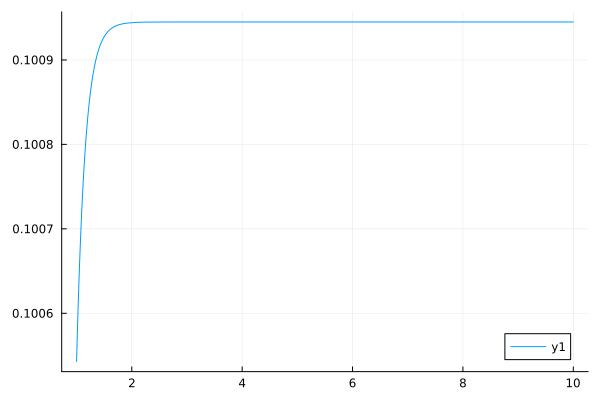

In [13]:
plot(η->ρ_o(η)-η, 1, 10)

Similarly, we would like to treat the image inside the circle; for $\eta>1$ we define 
$$
\rho_i(\eta) :=-\frac{1}{2\pi}\log\left(\max_{\theta \in [0, 1]}\left|B_{\mu}(e^{2\pi (-\eta + i \theta)})\right|\right)
$$

In [14]:
ρ_i(η) = -log(maximum(abs.(B.([exp(2 * π*(-η + im * θ)) for θ in 0:0.001:1]))))/(2*π)

ρ_i (generic function with 1 method)

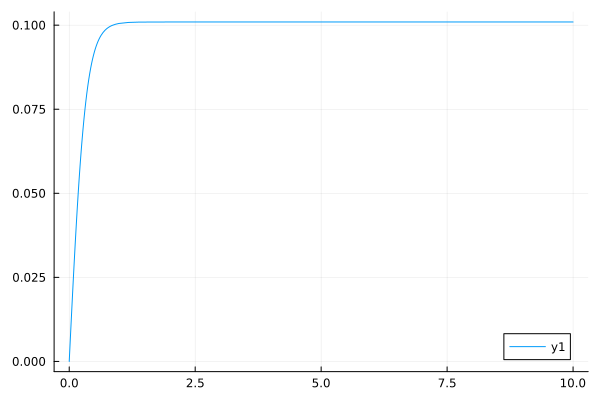

In [15]:
plot(η->ρ_i(η)-η, 0, 10)

We define now 
$$
\rho(\eta) = \min\{\rho_i(\eta),\rho_o(\eta)\}-\eta
$$
we have that our dynamic is expanding the annulus when this function is positive.

In [16]:
ρ(η) = min(ρ_i(η), ρ_o(η))

ρ (generic function with 1 method)

We plot now the function 
$$
    \eta \mapsto \rho(\eta)-\eta
$$
our dynamic is expanding the annulus when this function is positive.

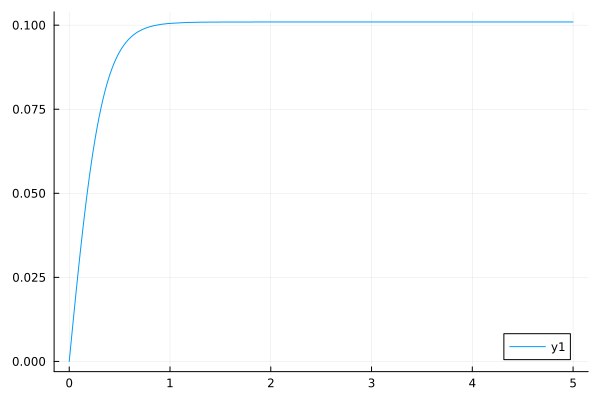

In [17]:
plot(η -> (ρ(η)-η), 0, 5)

From this non certified plot, we can see that the the difference $\rho(\eta)-\eta$ seems to converge to an asymptotic value bigger than 
$0.04551$.

We need now to be careful in choosing $\eta$ and $\rho$ in such a way that our computation is well behaved.

By our numerical exploration of the pseudospectrum, we want to isolate the eigenvalues outside of a circle of radius $0.5$.

By Lemma 3.10 and Lemma 3.13, we have that 
$$
\frac{||f||_{\mathcal{A}_{\alpha}}}{||f||_{\mathcal{A}_{0}}}\leq 2^{\frac{\alpha}{\alpha-\eta}} \left(1+\frac{2}{e^{2 \pi (\rho - \alpha)} - 1}\right)^{\frac{\alpha}{\alpha-\eta}} 
$$
and
$$
||\mathcal{L}-\mathcal{L}_K||_{\mathcal{A}_{\alpha}\to \mathcal{A}_0}\leq \left(1+\frac{2}{e^{2 \pi (\rho - \alpha)} - 1}\right)\left(e^{-2\pi K\alpha}+e^{-2\pi K(\alpha-\eta)}\right).
$$

We refer to Proposition 2 in the paper, what we would like to control and make small is
$$
||\mathcal{L}-\mathcal{L}_K||_{\mathcal{A}_{\alpha}\to \mathcal{A}_0}\frac{||f||_{\mathcal{A}_{\alpha}}}{||f||_{\mathcal{A}_{0}}};
$$
since $\rho>\alpha$ we have then that $\alpha-\eta$ is at most $0.04551$.

To optimize this, we pass to the logarithm.

In [18]:
bound(η, ρ, α; K, μ) =  α/(α-η)*log2(1/μ)+(α/(α-η)+1)*log2(1+2/(exp(2*π*(ρ-α))-1))+log2(exp(-2*π*K*α)+exp(-2*π*K*(α-η)))

bound (generic function with 1 method)

In [19]:
bound_η_α(η, α; K, μ) = bound(η, ρ(η), α; K, μ)

bound_η_α (generic function with 1 method)

In [20]:
function bound_η(η; K, μ)
    η_eps = η+(ρ(η)-η)/100
    ρ_eps = ρ(η)-(ρ(η)-η)/100
    val, index = findmin([bound_η_α(η, α; K, μ) for α in LinRange(η_eps, ρ_eps, 100)])
    return val, LinRange(η_eps, ρ_eps, 100)[index]
end

bound_η (generic function with 1 method)

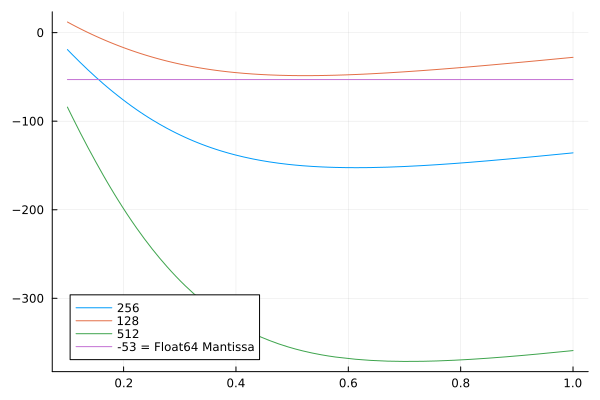

In [21]:
xmin = 0.1
xmax = 1.0
plot(η -> bound_η(η; K = 256, μ = 1/2)[1], xmin, xmax, label = "256")
plot!(η -> bound_η(η; K = 128, μ = 1/2)[1], xmin, xmax, label = "128")
#plot!(η -> bound_η(η; K = 64, μ = 1/2)[1], xmin, xmax, label = "64")
plot!(η -> bound_η(η; K = 512, μ = 1/2)[1], xmin, xmax, label = "512")
#plot!(η -> bound_η(η; K = 1024, μ = 1/2)[1], xmin, xmax, label = "1024")
plot!(η -> -53, label = "-53 = Float64 Mantissa")

We choose a discretization size of $K=256$. For this discretization size we fix $\eta = 0.52865$

In [22]:
steps = 1000
val, index = findmin([bound_η(η; K = 128, μ = 1/2)[1] for η in LinRange(0.25, 1.0, steps)])

(-48.56284178878137, 365)

In [23]:
chosen_η = LinRange(0.2, 1.0, steps)[index]
chosen_α = bound_η(chosen_η; K = 128, μ = 1/2)[2]

0.5758488557738615

By Proposition 3.14, we have that the eigenvalues of modulus bigger than $1/2$ of $\mathcal{L}$ are contained 
in $\sigma_\delta$ for all $\delta\geq 2^{-65}$, where 
$$
\sigma_{\delta} = \sigma(\mathcal{L_K})\cup \{z \in \mathbb{C} \mid z-\mathcal{L}_K\textrm{ is bounded invertible and } |(z-\mathcal{L}_K)^{-1}|> \delta^{-1}|\}
$$

# Certifying the constants

For the specific values of $\alpha$, $\rho$ and $\eta$ computed above, we will certify the value of the constants.

We will repeat the process above to estimate $\rho$, by enclosing the image of the annulus of radius $2\pi\eta$, by using now interval arithmetic to 
obtain guaranteed enclosures.

In [24]:
N = 32768
IΘ = [Interval(i, i+1)/N for i in 0:N-1];

In [25]:
ρ_o_c(η; IΘ) = log(minimum(abs.(B.([exp(2 * π*(η + im * θ)) for θ in IΘ]))))/(2*π)
ρ_i_c(η; IΘ) = -log(maximum(abs.(B.([exp(2 * π*(-η + im * θ)) for θ in IΘ]))))/(2*π)
ρ_c(η; IΘ) = min(ρ_i_c(η; IΘ), ρ_o_c(η; IΘ))

ρ_c (generic function with 1 method)

For the chosen $\eta$ we have that our oracle for $\rho$ returns

In [26]:
ρ(chosen_η)

0.5831138619133744

The certificate $\rho$ has some overestimates, but we can make this error small by taking a big partition $I\Theta$

In [27]:
ρ_certified = Interval((ρ_c(chosen_η; IΘ)).lo) 

[0.583052, 0.583053]

After all computations, our chosen $\alpha$, $\eta$ and certified $\rho$ are

In [28]:
chosen_η, ρ_certified, chosen_α

(0.4914914914914915, [0.583052, 0.583053], 0.5758488557738615)

And the certified bound is 

In [29]:
δ = 2^bound(Interval(chosen_η), ρ_certified, Interval(chosen_α); K = 128, μ = 0.35)

[3.35029e-14, 3.3503e-14]

In [30]:
bound_r(η, ρ, α; μ) =  α/(α-η)*log2(1/μ)+(α/(α-η))*log2(1+2/(exp(2*π*(ρ-α))-1))

bound_r (generic function with 1 method)

In [31]:
r = 2^bound_r(Interval(chosen_η), ρ_certified, Interval(chosen_α); μ = 0.35)

[2.20844e+14, 2.20845e+14]

# Optimizing the exclosure radius

In [34]:
using LinearAlgebra
F = schur(midP)

Schur{ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
T factor:
257×257 Matrix{ComplexF64}:
 0.489961+0.202949im  1.01344e-13+6.3498e-14im  …   2.57794e-17-3.96034e-17im
      0.0+0.0im          0.489961-0.202949im        4.50693e-17+1.42045e-17im
      0.0+0.0im               0.0+0.0im              1.5118e-17+7.9201e-17im
      0.0+0.0im               0.0+0.0im             2.15927e-17+7.7686e-17im
      0.0+0.0im               0.0+0.0im            -9.44576e-17-3.21684e-17im
      0.0+0.0im               0.0+0.0im         …   5.59516e-17+8.26223e-17im
      0.0+0.0im               0.0+0.0im            -3.36175e-17-1.27437e-17im
      0.0+0.0im               0.0+0.0im              8.5597e-17-6.56496e-17im
      0.0+0.0im               0.0+0.0im             -5.7659e-17+7.29237e-17im
      0.0+0.0im               0.0+0.0im             2.08327e-17+1.13396e-16im
         ⋮                                      ⋱  
      0.0+0.0im               0.0+0.0im            -4.19593e-17+5.00161e-1

In [57]:
r2 = abs.(F.values)[1]
r1 = abs.(F.values)[3]

0.28125000017250834

In [48]:
[z/svd(z*I-F.T).S[end] for z in LinRange(r1, r2, 1000)]

1000-element Vector{Float64}:
      1.030116275295398e6
      1.0204446287371024e6
      1.0108725675335885e6
      1.0013989817701025e6
 992022.7748560023
 982742.8622847417
 973558.1737190066
 964467.6503708054
 955470.2477718666
 946564.9317376022
      ⋮
   1435.19981714344
   1428.0107832388544
   1420.8604711221458
   1413.748659743585
   1406.675129399264
   1399.6396617208056
   1392.6420396673975
   1385.6820475188424
   1378.7594708636977

In [54]:
function heuristic(r, T, N = 128)
    sum = 0.0
    for θ in LinRange(0, 1, N)
        z = r*(cos(θ) +im*sin(θ))
        sum += 1/(svd(z*I-F.T).S[end])
    end
    return sum*2*π*r/N
end

heuristic (generic function with 2 methods)

In [ ]:
w = [heuristic(r, F.T) for r in LinRange(r1, r2, 100)]

100-element Vector{Float64}:
     2.206254979470621e8
     1.3357864011386056e8
     1.007787084534014e8
     8.06510999257656e7
     6.631826701845685e7
     5.5432663560372114e7
     4.686137949067144e7
     3.9954052871519715e7
     3.4296305854160905e7
     2.960535858359098e7
     ⋮
 52986.5093114552
 51803.54542739469
 50879.516926557546
 50269.34558878931
 50072.362235415254
 50485.29508265254
 51971.5082164999
 56239.8473098386
 84581.41365225059

In [56]:
LinRange(r1, r2, 100)[end-4]

0.5202662440429459